In [1]:
%load_ext lab_black
%load_ext autotime
import numpy as np
import pandas as pd

time: 261 ms (started: 2022-09-18 22:44:17 -07:00)


The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32 x 32 color images evenly divided across 10 classes (e.g. airplane, cat, truck, bird). This dataset does not embed very well with any dimensionality reduction method I am aware of, but the activation layers of a convolutional neural network trained with it was visualized via [Barnes-Hut t-SNE](http://jmlr.org/papers/v15/vandermaaten14a.html).

## Load the data

In [2]:
import pickle
import tarfile
from io import BytesIO

import requests

n_images = 60000
nx = 32
ny = 32
n_channels = 3
n_features = nx * ny * n_channels
n_batches = 5
n_images_per_batch = 10000

data = np.empty((n_images, n_features), dtype=np.uint8)
labels = np.empty((n_images,), dtype=np.uint8)

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
req = requests.get(url, timeout=10)
with tarfile.open(fileobj=BytesIO(req.content), mode="r") as tar_obj:
    # training batches
    for i in range(n_batches):
        batch_id = i + 1
        batch_pkl = tar_obj.extractfile(f"cifar-10-batches-py/data_batch_{batch_id}")
        batch = pickle.load(batch_pkl, encoding="bytes")
        data[(i * n_images_per_batch) : (i + 1) * n_images_per_batch] = batch[b"data"]
        labels[(i * n_images_per_batch) : (i + 1) * n_images_per_batch] = batch[
            b"labels"
        ]

    # test batch
    batch_pkl = tar_obj.extractfile(f"cifar-10-batches-py/test_batch")
    batch = pickle.load(batch_pkl, encoding="bytes")
    data[50000:] = batch[b"data"]
    labels[50000:] = batch[b"labels"]

    # label names
    batches_meta = pickle.load(
        tar_obj.extractfile(f"cifar-10-batches-py/batches.meta"), encoding="bytes"
    )
    label_names = np.array([x.decode("UTF-8") for x in batches_meta[b"label_names"]])

data.shape, labels.shape, label_names

((60000, 3072),
 (60000,),
 array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'], dtype='<U10'))

time: 11.3 s (started: 2022-09-18 22:44:18 -07:00)


## View image

Converting the images back into a form that `matplotlib` can handle requires some contortions. See [this stack overflow question](https://stackoverflow.com/q/35995999/4096483) for many, many suggestions on how to go about this and [this binary study blogpost](https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html#reshape) which is very straightforward. Also, the CIFAR10 are only 32 x 32 and if you view them at too large a size, it will be almost impossible to tell if you are actually looking at an image that has been correctly decoded.

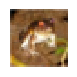

time: 539 ms (started: 2022-09-18 22:44:29 -07:00)


In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(0.75, 0.75))
plt.axis("off")
plt.imshow(
    data[0].reshape(3, 32, 32).transpose(1, 2, 0),
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

# The reshaping and transposing above is the equivalent of:
#     im_r = data[0, :1024].reshape(32, 32)
#     im_g = data[0, 1024:2048].reshape(32, 32)
#     im_b = data[0, 2048:].reshape(32, 32)
#     img = np.dstack((im_r, im_g, im_b))

Squint hard enough and you'll see that's a frog and hence `labels[0] == 6`.

## Pipeline

In [4]:
target = pd.DataFrame(dict(labels=labels, description=label_names[labels]))
target

,labels,description
0,6,frog
1,9,truck
2,9,truck
3,4,deer
4,1,automobile
...,...,...
59995,8,ship
59996,3,cat
59997,5,dog
59998,1,automobile


time: 20.9 ms (started: 2022-09-18 22:44:29 -07:00)


In [5]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "cifar10",
    data=data,
    target=target,
    tags=["image"],
    url="https://www.cs.toronto.edu/~kriz/cifar.html",
    verbose=True,
)

[22:44:33] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=918583;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=761733;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (60000, 3072)                                                ]8;id=281728;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=533970;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=236714;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=760771;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (60000, 3072)                               ]8;id=444041;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=840090;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=533699;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=723300;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (60000, 3072)                                   ]8;id=434212;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=989732;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[22:44:37] INFO     Checked for duplicates: found 0                                                 ]8;id=913262;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=290250;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=79141;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=52322;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=441965;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=459454;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for cifar10                                                        ]8;id=11661;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=596773;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[22:45:48] INFO     Processing target with initial shape (60000, 2)                                 ]8;id=182837;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=432595;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=105957;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=539551;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for cifar10                                                      ]8;id=587711;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=442679;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=703123;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=763928;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=103353;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=744444;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=981692;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=514760;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=598176;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=214577;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=545833;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=362844;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

[22:45:49] INFO     Successfully loaded faiss.                                                         ]8;id=296398;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=624898;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[22:45:57] INFO     Writing csv format to nn/cifar10.16.euclidean.exact.faiss.idx.csv               ]8;id=521517;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=344342;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

           INFO     Writing numpy format to nn/cifar10.16.euclidean.exact.faiss.idx.npy             ]8;id=971793;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=795923;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:46:00] INFO     Writing csv format to nn/cifar10.16.euclidean.exact.faiss.dist.csv              ]8;id=231335;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=206751;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:01] INFO     Writing numpy format to nn/cifar10.16.euclidean.exact.faiss.dist.npy            ]8;id=914599;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=185155;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:46:02] INFO     Writing csv format to nn/cifar10.51.euclidean.exact.faiss.idx.csv               ]8;id=273610;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=8655;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:04] INFO     Writing numpy format to nn/cifar10.51.euclidean.exact.faiss.idx.npy             ]8;id=190884;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=275320;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:46:10] INFO     Writing csv format to nn/cifar10.51.euclidean.exact.faiss.dist.csv              ]8;id=776938;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=438190;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:13] INFO     Writing numpy format to nn/cifar10.51.euclidean.exact.faiss.dist.npy            ]8;id=878099;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=124073;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:46:16] INFO     Writing csv format to nn/cifar10.151.euclidean.exact.faiss.idx.csv              ]8;id=462086;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=136615;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:23] INFO     Writing numpy format to nn/cifar10.151.euclidean.exact.faiss.idx.npy            ]8;id=918677;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=973338;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:46:24] INFO     Writing csv format to nn/cifar10.151.euclidean.exact.faiss.dist.csv             ]8;id=107383;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=525394;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:33] INFO     Writing numpy format to nn/cifar10.151.euclidean.exact.faiss.dist.npy           ]8;id=679235;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=478447;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Calculating triplets                                                            ]8;id=450446;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=707716;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[22:46:37] INFO     Writing csv format to triplets/cifar10.5.1337.idx.csv                           ]8;id=732641;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=420513;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:38] INFO     Writing csv format to triplets/cifar10.5.1337.l2.csv                            ]8;id=264887;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=122345;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:39] INFO     Writing numpy format to triplets/cifar10.5.1337.idx.npy                         ]8;id=593904;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=318747;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing numpy format to triplets/cifar10.5.1337.l2.npy                          ]8;id=43086;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=649521;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing pipeline result for cifar10                                             ]8;id=758320;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=531864;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 2min 9s (started: 2022-09-18 22:44:29 -07:00)


### PCA Pipeline

I have no expectations that this is useful, but in combination with other datasets, it can be useful to explore the effect on the nearest neighbor graph.

In [6]:
_ = create_default_pipeline(check_for_duplicates=True, reduce=50).run(
    "cifar10-pca50",
    data=data,
    target=target,
    tags=["image"],
    url="https://www.cs.toronto.edu/~kriz/cifar.html",
    verbose=True,
)

           INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=74680;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=77608;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (60000, 3072)                                                ]8;id=566182;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=662982;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=489831;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=11593;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (60000, 3072)                               ]8;id=234262;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=556051;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=15497;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=430762;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (60000, 3072)                                   ]8;id=233786;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=158119;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[22:46:44] INFO     Checked for duplicates: found 0                                                 ]8;id=360463;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=338674;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=165651;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=603550;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=627030;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=288040;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Reducing initial dimensionality to 50                                           ]8;id=133891;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=12199;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#170\170]8;;\

[22:46:54] INFO     PCA: 50 components explain 84.28% of variance                                   ]8;id=559444;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=309487;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#173\173]8;;\

           INFO     Data shape after PCA: (60000, 50)                                               ]8;id=983692;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=864517;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#179\179]8;;\

           INFO     Writing data for cifar10-pca50                                                  ]8;id=614042;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=755540;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[22:46:57] INFO     Processing target with initial shape (60000, 2)                                 ]8;id=657633;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=933524;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=21461;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=383088;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for cifar10-pca50                                                ]8;id=965595;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=594175;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[22:46:58] INFO     Calculating nearest neighbors                                                   ]8;id=177649;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=136990;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=480174;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=987051;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Writing csv format to nn/cifar10-pca50.16.euclidean.exact.faiss.idx.csv         ]8;id=851491;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=990368;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:46:59] INFO     Writing numpy format to nn/cifar10-pca50.16.euclidean.exact.faiss.idx.npy       ]8;id=179410;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=448909;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:47:01] INFO     Writing csv format to nn/cifar10-pca50.16.euclidean.exact.faiss.dist.csv        ]8;id=683816;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=494506;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:02] INFO     Writing numpy format to nn/cifar10-pca50.16.euclidean.exact.faiss.dist.npy      ]8;id=536153;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=650318;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:47:03] INFO     Writing csv format to nn/cifar10-pca50.51.euclidean.exact.faiss.idx.csv         ]8;id=192400;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=849507;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:06] INFO     Writing numpy format to nn/cifar10-pca50.51.euclidean.exact.faiss.idx.npy       ]8;id=353936;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=794175;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:47:12] INFO     Writing csv format to nn/cifar10-pca50.51.euclidean.exact.faiss.dist.csv        ]8;id=34295;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=525977;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:15] INFO     Writing numpy format to nn/cifar10-pca50.51.euclidean.exact.faiss.dist.npy      ]8;id=144000;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=228576;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

[22:47:18] INFO     Writing csv format to nn/cifar10-pca50.151.euclidean.exact.faiss.idx.csv        ]8;id=801780;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=495418;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:25] INFO     Writing numpy format to nn/cifar10-pca50.151.euclidean.exact.faiss.idx.npy      ]8;id=527222;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=137597;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing csv format to nn/cifar10-pca50.151.euclidean.exact.faiss.dist.csv       ]8;id=238581;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=195296;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:34] INFO     Writing numpy format to nn/cifar10-pca50.151.euclidean.exact.faiss.dist.npy     ]8;id=689895;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=497745;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Calculating triplets                                                            ]8;id=909568;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=65571;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[22:47:37] INFO     Writing csv format to triplets/cifar10-pca50.5.1337.idx.csv                     ]8;id=583702;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=488401;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:38] INFO     Writing csv format to triplets/cifar10-pca50.5.1337.l2.csv                      ]8;id=360946;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=158961;file:///home/james/dev/drnb/src/drnb/io/__init__.py#220\220]8;;\

[22:47:40] INFO     Writing numpy format to triplets/cifar10-pca50.5.1337.idx.npy                   ]8;id=300945;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=937209;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing numpy format to triplets/cifar10-pca50.5.1337.l2.npy                    ]8;id=803004;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=36054;file:///home/james/dev/drnb/src/drnb/io/__init__.py#243\243]8;;\

           INFO     Writing pipeline result for cifar10-pca50                                       ]8;id=591206;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=717847;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 1min (started: 2022-09-18 22:46:39 -07:00)
